<a href="https://colab.research.google.com/github/adrian-lison/gnn-community-detection/blob/master/Notebooks/KarateCora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Karate Cora


In [1]:
%matplotlib inline
!pip install dgl

## Imports

In [2]:
from dgl.data import citation_graph as citegrh
import dgl
import dgl.function as fn

import torch as th
import torch.nn as nn
import torch.nn.functional as F


from dgl import DGLGraph
import time
import numpy as np

## Data Loading

In [179]:
#Loading CORA
data = citegrh.load_cora()
features = th.FloatTensor(data.features)
labelsCORA = th.LongTensor(data.labels)
mask = th.ByteTensor(data.train_mask)
g = data.graph

# Add self-loop edges
g.remove_edges_from(g.selfloop_edges()) # just to be sure, remove any selfloop edges currently present
g = DGLGraph(g) # turn networkx graph into DGL graph
g.add_edges(g.nodes(), g.nodes()) # add the selfloop edges

In [ ]:
# Use one-hot encoded node IDs as features
g.ndata['feat'] = torch.eye(2708)

In [4]:
print('We have %d nodes.' % g.number_of_nodes())
print('We have %d edges.' % g.number_of_edges())

We have 2708 nodes.
We have 13264 edges.


## GNN Definition

In [7]:
# Define the message & reduce function
# NOTE: we ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges 
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [8]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(2708, 21, 7)

In [9]:
import random as rng

def get_label(x):
  return(int(labelsCORA[x]))

#Percentage of nodes known for training
percentage_open_nodes = 0.02
graph_node_size = int(G.number_of_nodes())
open_nodes = rng.sample(range(0,graph_node_size),int(graph_node_size*percentage_open_nodes))
open_nodes_labels = list(map(get_label,open_nodes))
len(open_nodes)

54

In [10]:
inputs = torch.eye(graph_node_size)
labeled_nodes = torch.tensor(open_nodes)  #
labels = torch.tensor(open_nodes_labels)  # 

In [173]:
mask

tensor([1, 1, 1,  ..., 0, 0, 0], dtype=torch.uint8)

In [11]:
#Helper to print accuracy
def output_accuracy(i,logits0):
  all_logits = logits0
  labels_final = []

  for v in range(graph_node_size):
    calculated_label = all_logits[i][v].numpy().argmax()
    labels_final.append(calculated_label)
  n_correct = 0
  n_correct_random = 0
  for v in range(graph_node_size):
    if (labels_final[v] == int(labelsCORA[v])):
      n_correct +=1
    if (int(rng.randrange(0,6)) == int(labelsCORA[v])):
      n_correct_random +=1
  print(f"Accuracy with {int(percentage_open_nodes*100)} labeled nodes: {np.round(n_correct/graph_node_size,2)} including {int(graph_node_size*percentage_open_nodes)} prelabeled nodes. Excluding: {np.round((n_correct-len(open_nodes))/(graph_node_size-len(open_nodes)),2)}")

## Training

In [174]:
net = GCN(2708, 21, 7)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[mask], labelsCORA[mask])
    val_loss = F.nll_loss(logp.detach(), labelsCORA)
    #val_loss=torch.tensor(42)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f | Total: %.4f' % (epoch, loss.item(), val_loss.item()))
    output_accuracy(epoch,all_logits)

Epoch 0 | Loss: 1.9485 | Total: 1.9520
Accuracy with 2 labeled nodes: 0.07 including 54 prelabeled nodes. Excluding: 0.06
Epoch 1 | Loss: 1.5364 | Total: 1.7452
Accuracy with 2 labeled nodes: 0.43 including 54 prelabeled nodes. Excluding: 0.42
Epoch 2 | Loss: 1.1952 | Total: 1.5628
Accuracy with 2 labeled nodes: 0.54 including 54 prelabeled nodes. Excluding: 0.53
Epoch 3 | Loss: 0.9331 | Total: 1.4244
Accuracy with 2 labeled nodes: 0.58 including 54 prelabeled nodes. Excluding: 0.57
Epoch 4 | Loss: 0.7477 | Total: 1.3297
Accuracy with 2 labeled nodes: 0.6 including 54 prelabeled nodes. Excluding: 0.59
Epoch 5 | Loss: 0.6113 | Total: 1.2653
Accuracy with 2 labeled nodes: 0.62 including 54 prelabeled nodes. Excluding: 0.61
Epoch 6 | Loss: 0.5062 | Total: 1.2230
Accuracy with 2 labeled nodes: 0.63 including 54 prelabeled nodes. Excluding: 0.62
Epoch 7 | Loss: 0.4224 | Total: 1.1976
Accuracy with 2 labeled nodes: 0.64 including 54 prelabeled nodes. Excluding: 0.64
Epoch 8 | Loss: 0.3542 | 

## Evaluation

In [175]:
from sklearn.metrics import accuracy_score as acc
net.eval() # Set net to evaluation mode (deactivates dropout)
final_prediction = net(G, inputs).detach()

pred_sets = {"All ":final_prediction,"Train":final_prediction[mask],"Test":final_prediction[1-mask]}
label_sets = {"All ":labelsCORA,"Train":labelsCORA[mask],"Test":labelsCORA[1-mask]}
eval_functions = {"NLL-Loss":lambda y,x: F.nll_loss(x,y),"Accuracy":lambda y,x: acc(y,x.numpy().argmax(axis=1))}

for name,func in eval_functions.items():
    eval_message = f"\n{name}:\n"
    for subset in pred_sets.keys():
        eval_message += f" {subset}: {func(label_sets[subset],pred_sets[subset]):.4f} |"
    print(eval_message)


NLL-Loss:
 All : -8.3750 | Train: -16.9419 | Test: -7.9079 |

Accuracy:
 All : 0.6739 | Train: 1.0000 | Test: 0.6562 |


## Visualisation

In [ ]:
#Create PCA feature transformation based on last epoch
final = 49
features_final = {}

for v in range(graph_node_size):
  features_final[v] = all_logits[final][v].numpy()

In [ ]:
#Show final features of first node
import pandas as pd
df = pd.DataFrame.from_dict(features_final,orient='index')
df.head(1)

In [ ]:
# Scaling before PCA
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 

X_train = sc.fit_transform(df) 

# Applying PCA function on training 
# and testing set of X component 
from sklearn.decomposition import PCA 
  
pca = PCA(n_components = 2) 
  
X_train = pca.fit_transform(X_train) 
#X_test = pca.transform(X_test) 
  
explained_variance = pca.explained_variance_ratio_ 
explained_variance

In [ ]:
#Apply to the previously calculated model
def tranform_with_pca(logits):
  X_test = sc.transform(pd.DataFrame(logits).transpose()) 
  X_test = pca.transform(X_test) 
  return(X_test[0])

In [ ]:
#Method to normalize a dataframe
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [ ]:
#Postions per epoch for PCA
pos_epochs = {}
for x in range(final+1):
  pos2d = {}
  for v in range(graph_node_size):
    pos2d[v] =  tranform_with_pca(all_logits[x][v].numpy())
  df = (pd.DataFrame(pos2d)).transpose()
  df_normalized = normalize(df)
  #Apply 0.35 Root to make outliers smaller
  df_normalized = df_normalized.applymap(lambda x : x**0.35)
  pos_epochs[x] = df_normalized

In [ ]:
#You could also use this for transforming and reducing outliers
import math
def fake_log(x):
  base = 1.5
  if (x == 0):
    return(0)
  if (x < 0):
    return(math.log((x*-1),base)*-1)
  else:
    return(math.log(x,base))

In [13]:
#Alternative: Create positions with tsne for ONE epoch
from sklearn.manifold import TSNE
import pandas as pd
pos_epochs = {}
pos_epochs[0] = pd.DataFrame(TSNE(n_components=2,n_iter=250).fit_transform(all_logits[0].numpy()))
for x in range(1,50):
    print(x)
    pos2d = {}
    pos_epochs[x] = pd.DataFrame(TSNE(n_components=2,init=pos_epochs[x-1].to_numpy(),n_iter=250).fit_transform(all_logits[x].numpy()))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [48]:
TSNE(n_components=2,n_iter=250).fit_transform(all_logits[0].numpy())[3]

array([-0.12923424,  0.04529409], dtype=float32)

In [169]:
import importlib
import Notebooks.GNN_Animation as gnn_anim
importlib.reload(gnn_anim)
pos_epochs2 = gnn_anim.GNN_Animation._compute_positions(all_logits)

In [106]:
pos_epochs = {k:v.to_numpy() for k,v in pos_epochs.items()}

C:\Users\a_liso02\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


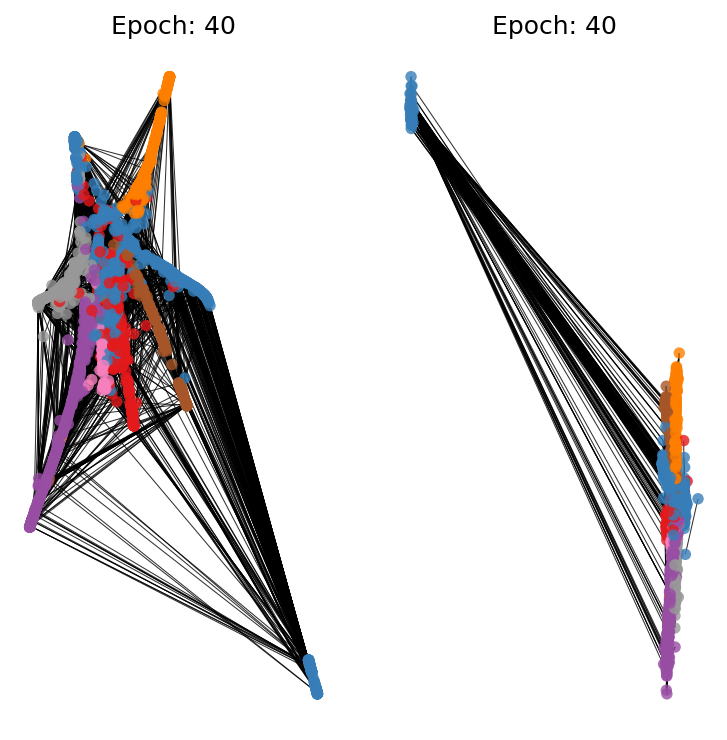

In [170]:
fig = plt.figure(dpi=150, figsize=(6, 6))
fig.clf()
ax = fig.subplots(ncols=2)
i=40
gnn_anim.GNN_Animation._draw(i,pos_epochs,all_logits,G.to_networkx().to_undirected(),ax[0])
gnn_anim.GNN_Animation._draw(i,pos_epochs2,all_logits,G.to_networkx().to_undirected(),ax[1])

In [168]:
#g1 = nx.erdos_renyi_graph(5,0.4)
#g1.add_edges_from(zip(range(5),range(5)))
print(nx.to_numpy_matrix(g1))
print(nx.laplacian_matrix(g1).todense())
lpmat = nx.laplacian_matrix(g1).todense()
lpmat = np.diag([d[1] for d in g1.degree])-nx.to_numpy_matrix(g1)
dmat = np.power(np.diag([d[1] for d in g1.degree]),-1/2)
dmat[np.isinf(dmat)]=0
print(dmat)
print(dmat*lpmat*dmat)
print(np.round(nx.normalized_laplacian_matrix(g1).todense(),2))
print(np.round(-nx.normalized_laplacian_matrix(g1).todense()+np.identity(5),4))
np.sum(-nx.normalized_laplacian_matrix(g1).todense()+np.identity(5),axis=1)

[[1. 0. 0. 1. 0.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[ 1  0  0 -1  0]
 [ 0  2 -1 -1  0]
 [ 0 -1  1  0  0]
 [-1 -1  0  2  0]
 [ 0  0  0  0  0]]
[[0.57735027 0.         0.         0.         0.        ]
 [0.         0.5        0.         0.         0.        ]
 [0.         0.         0.57735027 0.         0.        ]
 [0.         0.         0.         0.5        0.        ]
 [0.         0.         0.         0.         0.70710678]]
[[ 0.66666667  0.          0.         -0.28867513  0.        ]
 [ 0.          0.75       -0.28867513 -0.25        0.        ]
 [ 0.         -0.28867513  0.66666667  0.          0.        ]
 [-0.28867513 -0.25        0.          0.75        0.        ]
 [ 0.          0.          0.          0.          0.5       ]]
[[ 0.5   0.    0.   -0.41  0.  ]
 [ 0.    0.67 -0.41 -0.33  0.  ]
 [ 0.   -0.41  0.5   0.    0.  ]
 [-0.41 -0.33  0.    0.67  0.  ]
 [ 0.    0.    0.    0.    0.  ]]
[[0.5    0.     0.     0.4082 0.    ]
 [0.   

matrix([[0.90824829],
        [1.07491496],
        [0.90824829],
        [1.07491496],
        [1.        ]])

In [155]:
print([d[1] for d in g1.degree])

[3, 4, 3, 4, 2]


In [27]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import networkx as nx
nx_G = G.to_networkx().to_undirected()

def draw(i):
    #cls1color = '#00FFFF'
    #cls2color = '#FF00FF'
    pos = {}
    pos2d = {}
    #colors = [l for l in logits]
    for v in range(graph_node_size):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        #Toggle next rows
        #pos2d[v] =  tranform_with_pca(pos[v])
        #pos2d[v] = df_normalized.loc[[v]].values[0]
        pos2d[v] = pos_epochs[i].loc[[v]].values[0]
        colors.append(cls)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    return nx.draw_networkx(nx_G.to_undirected(), pos=pos2d , node_color=colors,
            with_labels=False, node_size=30, ax=ax, width=0.5, alpha=0.8, linewidths=0)

In [51]:
i=3
pos = {}
pos2d = {}
colors = []
for v in range(graph_node_size):
    pos[v] = all_logits[i][v].numpy()
    cls = pos[v].argmax()
    #Toggle next rows
    #pos2d[v] =  tranform_with_pca(pos[v])
    #pos2d[v] = df_normalized.loc[[v]].values[0]
    pos2d[v] = pos_epochs[i].loc[[v]].values[0]
    colors.append(cls)
pos2d

),
 633: array([ 1.9870435, -2.3115492], dtype=float32),
 634: array([-0.95166296, -0.74454117], dtype=float32),
 635: array([-0.9280235 , -0.75016546], dtype=float32),
 636: array([ 1.987024 , -2.2276652], dtype=float32),
 637: array([-2.146748 ,  1.3342779], dtype=float32),
 638: array([ 2.1568995, -1.6190695], dtype=float32),
 639: array([-0.694717 ,  0.4320314], dtype=float32),
 640: array([ 0.44502538, -0.4964249 ], dtype=float32),
 641: array([-0.41582328,  1.1905105 ], dtype=float32),
 642: array([-2.092564 ,  1.2499704], dtype=float32),
 643: array([1.0936905 , 0.04488599], dtype=float32),
 644: array([ 1.9546957, -2.2559295], dtype=float32),
 645: array([-0.18763286,  1.2918333 ], dtype=float32),
 646: array([-2.2059028,  1.2002537], dtype=float32),
 647: array([-2.5613418,  1.3368456], dtype=float32),
 648: array([-2.5967987,  1.3027256], dtype=float32),
 649: array([ 1.6957201 , -0.04907607], dtype=float32),
 650: array([ 1.2422805, -0.510035 ], dtype=float32),
 651: array([

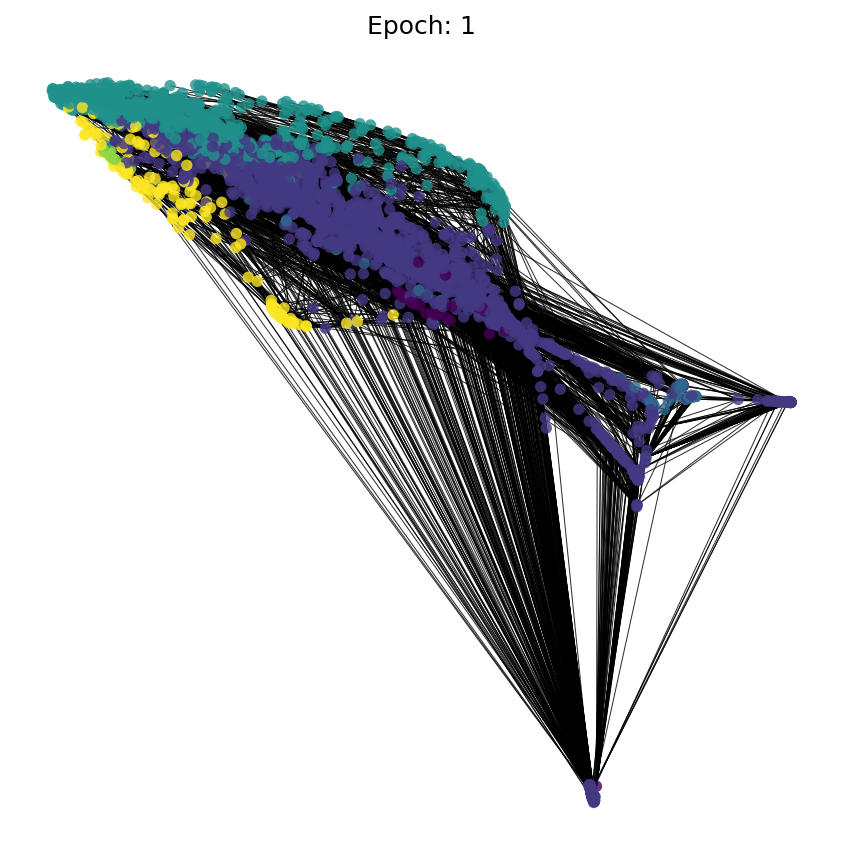

In [93]:
fig = plt.figure(dpi=150,figsize=(7, 7))
fig.clf()
ax = fig.subplots()
draw(1)  # draw the prediction of the first epoch
#plt.close()

In [52]:
#ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=100)
fig = plt.figure(dpi=150,figsize=(7, 7))
fig.clf()
ax = fig.subplots()
#draw(0)  # draw the prediction of the first epoch
ani = animation.FuncAnimation(fig, draw, frames=5, interval=200, repeat_delay=1500)
ani_html = ani.to_jshtml()
plt.close()

C:\Users\a_liso02\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


In [92]:
{k:pos[0:2] for k,pos in enumerate(pos_epochs[0].to_numpy())}

8  , -0.56265044], dtype=float32),
 641: array([0.05827989, 0.07977923], dtype=float32),
 642: array([-0.9193599 ,  0.50947684], dtype=float32),
 643: array([ 1.110433  , -0.60843945], dtype=float32),
 644: array([ 0.3622195 , -0.33046678], dtype=float32),
 645: array([ 0.05748907, -0.06026988], dtype=float32),
 646: array([-0.9745288,  0.5599301], dtype=float32),
 647: array([-1.0150753,  0.6223439], dtype=float32),
 648: array([-1.033148 ,  0.6353756], dtype=float32),
 649: array([ 1.0985737, -0.6065737], dtype=float32),
 650: array([ 0.9832365 , -0.44043472], dtype=float32),
 651: array([ 0.09862183, -0.20455703], dtype=float32),
 652: array([-0.2935248 ,  0.17251381], dtype=float32),
 653: array([-0.19269246,  0.17806382], dtype=float32),
 654: array([-0.705772  ,  0.38320777], dtype=float32),
 655: array([0.47517595, 0.06516484], dtype=float32),
 656: array([ 0.6460085 , -0.22554883], dtype=float32),
 657: array([-0.04629163,  0.16899168], dtype=float32),
 658: array([ 0.5805781 ,

In [88]:
import importlib
import Notebooks.GNN_Animation as gnn_anim
importlib.reload(gnn_anim)
ani, ani_html = gnn_anim.GNN_Animation.animate(G,all_logits[0:4])

C:\Users\a_liso02\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


In [89]:
from IPython.display import HTML
HTML(ani_html)